In [42]:
import h5py
import scipy.io as io
import PIL as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter 
import scipy
from scipy import spatial
import json
from matplotlib import cm as CM
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import mean_squared_error
from keras.initializers import RandomNormal
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.models import Model,Sequential
from keras.layers import *
from keras import backend as K
from keras.models import model_from_json
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import cv2
import random
import math
import sys

# Functions

In [71]:
def gaussian_filter_density(ground_truth):
    '''Generates a density map using Gaussian filter transformation.'''
    density = np.zeros(ground_truth.shape, dtype=np.float32)
    ground_truth_count = np.count_nonzero(ground_truth)
    
    if ground_truth_count == 0:
        return density

    # Find out the K nearest neighbours using a KDTree
    index_of_nonzero_elements = np.nonzero(ground_truth)
    points = np.array(list(zip(index_of_nonzero_elements[1].ravel(), index_of_nonzero_elements[0].ravel())))
    leafsize = 2048
    
    # build kdtree
    tree = spatial.KDTree(points.copy(), leafsize=leafsize)
    # query kdtree
    distances, _ = tree.query(points, k=4)
        
    for i, point in enumerate(points):
        point_2d = np.zeros(ground_truth.shape, dtype=np.float32)
        point_2d[point[1],point[0]] = 1.
        if ground_truth_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(ground_truth.shape))/2./2. #case: 1 point
        
        #Convolve with the gaussian filter
        density += gaussian_filter(point_2d, sigma, mode='constant')
    return density

def get_labels_shangai(img_paths):
    labels = []
    for img_path in img_paths:
        mat_file = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
        ground_truth = mat_file["image_info"][0,0][0,0][0]
    
        img= plt.imread(img_path)
        k = np.zeros((img.shape[0],img.shape[1]))
        for j in range(len(ground_truth)):
            if int(ground_truth[j][1])<img.shape[0] and int(ground_truth[j][0])<img.shape[1]:
                k[int(ground_truth[j][1]), int(ground_truth[j][0])]=1

        labels.append(k.sum())
    return labels


def create_density_maps_shangai(img_paths):
    """For each path given, loads the corresponding image and its ground truth. 
    The ground truth can be seen as the x,y coordinates of the detected personds. 
    Out of this ground truth a hot encoded matrix is generated for the image. 
    This is a matrix with same shape as the image, and whose all values are 0 except
    for those where a person is found (with value 1). From this matrix the density 
    map is constructed via gaussian transformations in another function and saved in h5 file. """
    for img_path in tqdm(img_paths):
        # Load sparse matrix
        mat_file = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
        #Read image
        img= plt.imread(img_path)
        # Create a zero matrix of image size
        k = np.zeros((img.shape[0],img.shape[1]))
        
        ground_truth = mat_file["image_info"][0,0][0,0][0]

        #Generate hot encoded matrix of sparse matrix
        for i in range(len(ground_truth)):
            if int(ground_truth[i][1])<img.shape[0] and int(ground_truth[i][0])<img.shape[1]:
                k[int(ground_truth[i][1]), int(ground_truth[i][0])]=1
        
        # generate density map
        k = gaussian_filter_density(k)
        
        # File path to save density map
        file_path = img_path.replace('.jpg','.h5').replace('images','density_maps')
        # Create directory if it doesn't exist
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))

        with h5py.File(file_path, 'w') as hf:
                hf['density'] = k

def create_density_maps_mall(imgs_mall, ground_truths, directory):
    for i in tqdm(range(len(imgs_mall))):
        # Create a zero matrix of image size
        img = imgs_mall[i]
        k = np.zeros((img.shape[0],img.shape[1]))
        
        ground_truth = ground_truths[i][0][0][0]

        #Generate hot encoded matrix of sparse matrix
        for j in range(len(ground_truth)):
            if int(ground_truth[j][1])<img.shape[0] and int(ground_truth[j][0])<img.shape[1]:
                k[int(ground_truth[j][1]), int(ground_truth[j][0])]=1
        
        # generate density map
        k = gaussian_filter_density(k)
        
        # File path to save density map
        file_path = directory + f'\IMG_{i+1}.h5'
        # Create directory if it doesn't exist
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))

        with h5py.File(file_path, 'w') as hf:
                hf['density'] = k

def change_names_of_mall_frames(folder_path = os.path.join('data', 'mall_dataset','frames')):
    """ Changes names of images from seq_00000x to IMG_x"""
    for i, filename in enumerate(os.listdir(folder_path)):
        last_number = int(filename[:-4][-6:])
        old_path = os.path.join(folder_path, filename)
        new_path = os.path.join(folder_path, f"IMG_{last_number}.jpg")
        os.rename(old_path, new_path)

def plot_histogram_with_mean_and_median(data):
    """Plots histogram of count of people detected in the images."""
    median = np.median(data)
    plt.hist(data, bins=20)
    plt.axvline(median, color='r', linestyle='--')
    plt.text(1.05*median, 100, 'Median', color='r')
    plt.xlabel('Number of people in the frame')
    plt.show()

def plot_density_map(file_path):
    """Plots the density map whose path is given"""
    ground_truth_file = h5py.File(file_path,'r')
    groundtruth = np.asarray(ground_truth_file['density'])
    plt.imshow(groundtruth,cmap=CM.jet)
    print("Sum = " , np.sum(groundtruth))

# Shangai dataset

## Load the data

In [51]:
part_A_train = os.path.join('data', 'shangai_dataset','part_A','train_data','images')
part_A_test = os.path.join('data', 'shangai_dataset','part_A', 'test_data','images')
part_B_train = os.path.join('data', 'shangai_dataset','part_B','train_data','images')
part_B_test = os.path.join('data', 'shangai_dataset','part_B','test_data','images')
path_sets = [part_A_train, part_A_test, part_B_train, part_B_test]


In [52]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
print(f'Number of images: {len(img_paths)}')
print(f'Example of image path: {img_paths[0]}')

Number of images: 1198
Example of image path: data\shangai_dataset\part_A\train_data\images\IMG_1.jpg


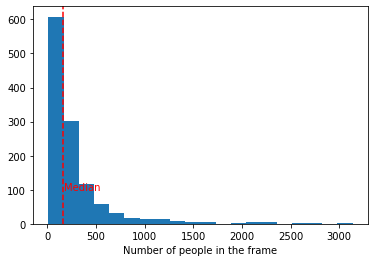

In [72]:
labels_shangai = get_labels_shangai(img_paths)
plot_histogram_with_mean_and_median(labels_shangai)

## Create density maps

In [24]:
create_density_maps_shangai(img_paths)

100%|██████████| 1198/1198 [3:31:44<00:00, 10.61s/it] 


Let's visualize the density map of an image.

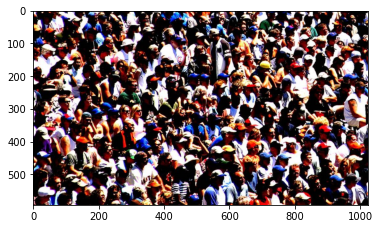

In [8]:
# Image
img_22 = Image.open(img_paths[22])
plt.imshow(img_22)

Sum =  210.5669


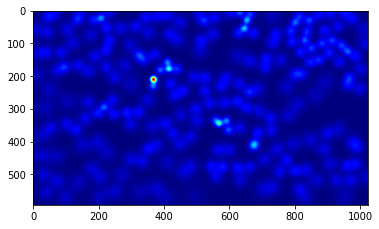

In [11]:
# Its density map
file_path_22 = img_paths[22].replace('.jpg','.h5').replace('images','density_maps') 
ground_truth_file_22 = h5py.File(file_path_22,'r')
groundtruth_22 = np.asarray(ground_truth_file_22['density'])
plt.imshow(groundtruth_22,cmap=CM.jet)
print("Sum = " ,np.sum(groundtruth_22))

## Modeling

In [23]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    im = np.array(im)
    im = im/255.0
    # the mean and standard deviation of the ImageNet dataset are used for normalization.
    # This type of normalization is commonly used in deep learning models trained on the 
    # ImageNet dataset to improve training performance and convergence.
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    return im

def get_input(path):
    path = path[0] 
    img = create_img(path)
    return(img)
    
def get_output(path):
    """import target, resize target"""
    gt_file = h5py.File(path,'r')
    target = np.asarray(gt_file['density'])
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    img = np.expand_dims(img,axis  = 2)
    #print(img.shape)
    return img

def preprocess_input(image,target):
    """#crop image, crop target, resize target"""
    crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))
    
    if random.randint(0,9)<= -1:            
            dx = int(random.randint(0,1)*image.shape[0]*1./2)
            dy = int(random.randint(0,1)*image.shape[1]*1./2)
    else:
            dx = int(random.random()*image.shape[0]*1./2)
            dy = int(random.random()*image.shape[1]*1./2)

    #print(crop_size , dx , dy)
    img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]
    target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]
    #print(img.shape)
    return(img,target_aug)

def image_generator(files, batch_size = 64):
    while True:
        input_path = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = [] 
          
        inputt = get_input(input_path)
        output = get_output(input_path[0].replace('.jpg','.h5').replace('images','density_maps') )
            
        batch_input += [inputt]
        batch_output += [output]
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        yield(batch_x, batch_y)

def save_mod(model , str1 , str2):
    model.save_weights(str1)
    model_json = model.to_json()
    with open(str2, "w") as json_file:
        json_file.write(model_json)


def init_weights_vgg(model):
    #vgg =  VGG16(weights='imagenet', include_top=False)
    json_file = open('models/VGG_16.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/VGG_16.h5")
    
    vgg = loaded_model
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    
    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
        else:
            offset=offset+1
    return (model)


def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [17]:
def CSRNet():  
    #Variable Input Size
    rows, cols = None, None

    #Batch Normalisation option
    batch_norm = 0
    kernel = (3, 3)
    init = RandomNormal(stddev=0.01)
    model = Sequential() 

    #custom VGG:
    if(batch_norm):
        model.add(Conv2D(64, kernel_size = kernel, input_shape = (rows,cols,3),activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(strides=2))
        model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(strides=2))
        model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(strides=2))            
        model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        
    else:
        model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
        model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
        model.add(MaxPooling2D(strides=2))
        model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
        model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
        model.add(MaxPooling2D(strides=2))
        model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
        model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
        model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
        model.add(MaxPooling2D(strides=2))            
        model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
        model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
        model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
        
    #Conv2D
    model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))

    sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
    model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
    # model = init_weights_vgg(model)
    return model

In [19]:
model = CSRNet()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, None, None, 64)    1792      
                                                                 
 conv2d_35 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 conv2d_36 (Conv2D)          (None, None, None, 128)   73856     
                                                                 
 conv2d_37 (Conv2D)          (None, None, None, 128)   147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                  

In [24]:
train_gen = image_generator(img_paths,1)

In [25]:
sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])

In [ ]:
history = model.fit(train_gen,epochs=1,steps_per_epoch= 700 , verbose=1)

In [ ]:
save_mod(model,"weights/model_A_weights.h5","models/Model.json")

In [ ]:
plt.plot(history.history["loss"])

# Mall dataset


## Load the data

In [50]:
images_mall = np.load(os.path.join('data', 'mall_dataset','images.npy'))
labels_mall = np.load(os.path.join('data', 'mall_dataset','labels.npy'))

print(f'Image array shape: {images_mall.shape}')
print(f'Labels array shape: {labels_mall.shape}')

Image array shape: (2000, 480, 640, 3)
Labels array shape: (2000, 1)


In [74]:
mall_gt = io.loadmat(os.path.join('data', 'mall_dataset','mall_gt.mat'))
mall_ground_truth = mall_gt['frame'][0]

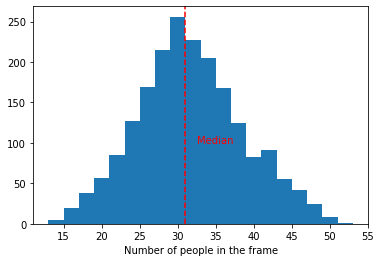

In [73]:
plot_histogram_with_mean_and_median(labels_mall)

## Create density map

In [49]:
create_density_maps_mall(images_mall, mall_ground_truth, directory = os.path.join('data', 'mall_dataset','density_maps'))

100%|██████████| 2000/2000 [38:25<00:00,  1.15s/it]


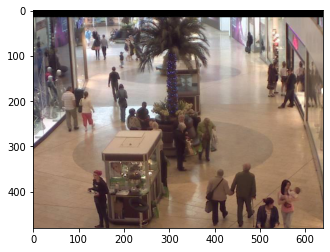

In [79]:
# Image
plt.imshow(np.uint8(images_mall[0]))
plt.show()

Sum =  28.295473


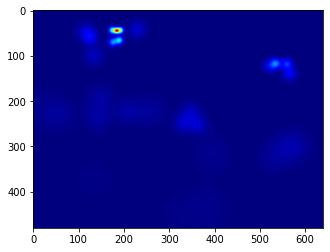

In [80]:
plot_density_map(file_path = os.path.join('data', 'mall_dataset','density_maps', 'IMG_1.h5'))

## Modeling

Let's do a train-test split:

In [33]:
X_train_mall, X_test_mall, y_train_mall, y_test_mall = train_test_split(images_mall, labels_mall, test_size=0.2, random_state=42)

# print the shapes of the train and test sets
print('X_train shape:', X_train_mall.shape)
print('y_train shape:', y_train_mall.shape)
print('X_test shape:', X_test_mall.shape)
print('y_test shape:', y_test_mall.shape)

X_train shape: (1600, 480, 640, 3)
y_train shape: (1600, 1)
X_test shape: (400, 480, 640, 3)
y_test shape: (400, 1)
